In [70]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [71]:
# Loading the merged train and test dataset

train_data = pd.read_pickle('merged_train.pkl')

In [72]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 434) 

*********************************************


## Utility Functions
<br>

In [73]:
def cat_num_features(df):
    
    '''
        Utility Function to get the names of Categorical Features and 
        Numerical Features of the given Dataset.
    '''
    
    catf = []
    numf = []
    
    # Given Categorical Features 
    catf = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', \
            'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', \
            'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', \
            'DeviceType', 'DeviceInfo']
    catf+=['id_'+str(i) for i in range(12,39)]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']
    
    return (catf, numf)  

In [74]:
def label_encode(X_train, catf):
  
  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:
    
    X_train[f] = X_train[f].astype(str)
    
    le = LabelEncoder()
    le.fit(X_train[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    X_train[f] = le.transform(X_train[f])
    
    # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    

  return (X_train)

## Data Preparation
<br>

### Splitting the Dataset
<br>

In [75]:
x = train_data.drop(['isFraud', 'TransactionID'], axis=1)
y = train_data['isFraud']



In [76]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(x.shape))
print("*"*45)

*********************************************

 Train Data Shape : (590540, 432) 

*********************************************


In [77]:
# Storing Categorical and Numerical Feature Names 

catf, numf = cat_num_features(x)
categorical_feature_indices = [x.columns.get_loc(f) for f in catf]

#### Label Encoding Categorical Features
<br>
We will be creating three sets, one having imputed missing values to be used with models which do not handle missing values on their own and the other whose missing values will be imputed and also it will be scaled between 0 and 1 to be used with models like Naive Bayes and Logisitic Regression and the third which is to be used with model like XgBoost which can handle missing values on its own.
<br><br>

In [78]:
x = label_encode(x, catf)

In [59]:
# Imputing the missing values of Categorical Columns with "missing"

x[catf] = x[catf].fillna('missing')


In [79]:
# Imputed and Normalized

x[numf] =x[numf].fillna(-999)
x[numf] = preprocessing.normalize(x[numf])

In [80]:
high_null_features_train = [f for f in x.columns if x[f].isna().sum()/len(x) > 0.9]

one_value_features_train = [f for f in x.columns if x[f].nunique()<=1]

constant_value_features_train = [f for f in x.columns if x[f].value_counts(dropna=False, normalize=True).values[0] > 0.9]
drop_cols = list(set(high_null_features_train+\
                     one_value_features_train+\
                     constant_value_features_train))

if 'isFraud' in drop_cols:
  drop_cols.remove('isFraud')

x.drop(drop_cols, axis=1, inplace=True)
# Storing the updated Categorical and Numerical Feature Names 

catf, numf = cat_num_features(x)
categorical_feature_indices = [x.columns.get_loc(f) for f in catf]

In [81]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(x_smote, x_smote)

In [83]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(X_train.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(X_test.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (854815, 391) 


 Test Dataset Set1 Shape : (284939, 391) 

************************************************************


## Base Line Models
<br>

<br>

### 1. Naive Bayes

<br>

In [84]:
nb = GaussianNB(priors=[0.5,0.5]) 
nb.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (854815, 391) instead.

([<matplotlib.axis.YTick at 0x7fd2a04565b0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

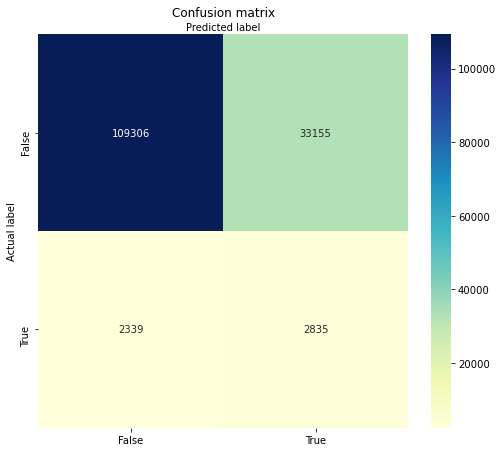

In [ ]:
y_predr = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_predr)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 2. Logistic Regression

<br>

In [73]:
lr = LogisticRegression(n_jobs = -1, class_weight = 'balanced', random_state = 3) 
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=3)

([<matplotlib.axis.YTick at 0x7fd6cb7cb9a0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

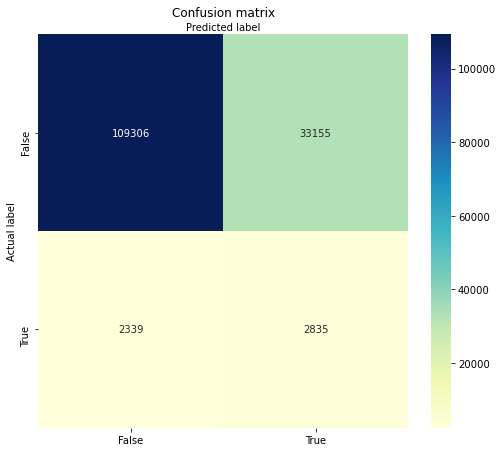

In [74]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 3. Random Forest

<br>

In [75]:
rf =  RandomForestClassifier(n_jobs = -1, class_weight = 'balanced', random_state = 3)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=3)

([<matplotlib.axis.YTick at 0x7fd6cb4484c0>,
 [Text(0, 0.5, 'False'), Text(0, 1.5, 'True')])

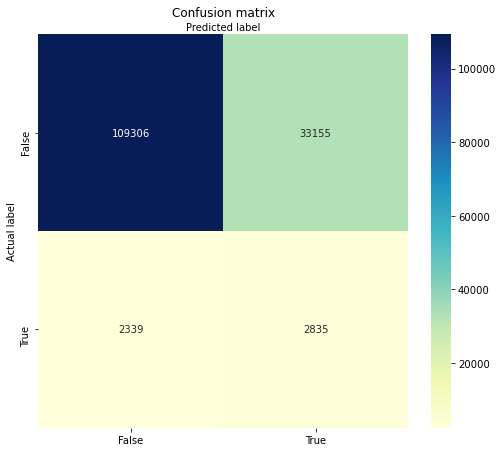

In [76]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 6. Support Vector Machine

<br>

In [78]:
sv = SVC()
sv.fit(X_train, y_train)


In [ ]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

<br>

### 7. Gradient Boosted Decision Tree (XGBoost)

<br>

In [ ]:
param_grid = {'gamma': [0.1,0.2,0.4],
              'learning_rate': [0.01, 0.03, 0.06],
              'max_depth': [5,6,7],
              'n_estimators': [50,65,80],
              'reg_alpha': [0,0.1,0.2,0.4],
              'reg_lambda': [0,0.1,0.2,0.4]}
grid = GridSearchCV(XGBClassifier(objective='binary:logistic'), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=27.579586700866283,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
y_pred = nb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
%matplotlib inline
class_names=[False, True] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)